[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Running: SPY


[*********************100%***********************]  1 of 1 completed


Running: QQQ


[*********************100%***********************]  1 of 1 completed


Running: AAPL


[*********************100%***********************]  1 of 1 completed


Running: MSFT


[*********************100%***********************]  1 of 1 completed


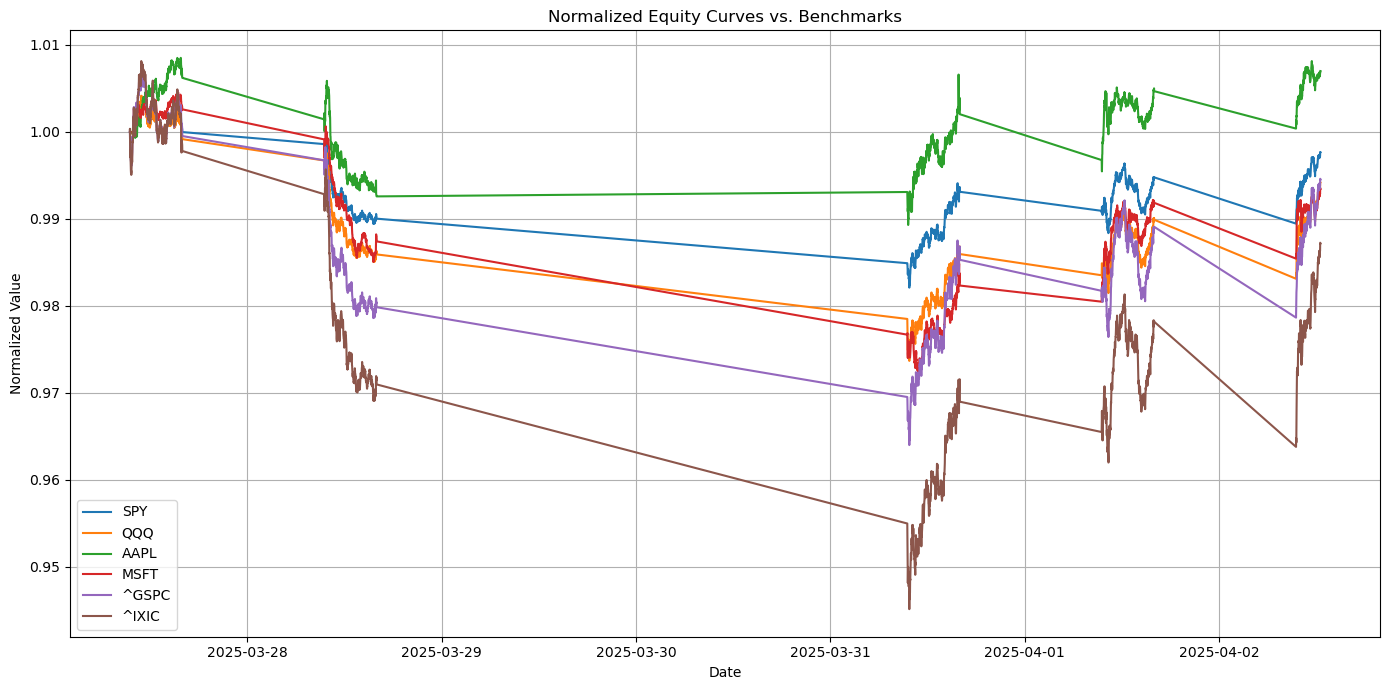


Multi-Ticker Strategy Results with Risk Metrics:



,Ticker,Final Value ($),Strategy Return (%),Buy & Hold Return (%),Outperformed (%),Buys,Sells,Trades,Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Status
0,SPY,19953.06,-0.23,-0.49,0.26,831,875,1706,-1.35,-1.37,-2.11,Beat Market
1,QQQ,19883.57,-0.58,-1.20,0.61,834,866,1700,-2.55,-2.55,-3.04,Beat Market
2,AAPL,20140.07,0.70,1.35,-0.65,848,844,1692,3.03,3.48,-1.90,Underperformed
3,MSFT,19869.62,-0.65,-1.35,0.70,835,861,1696,-2.51,-2.33,-3.22,Beat Market


In [201]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Strategy Configuration
# ------------------------------

tickers = ["SPY", "QQQ", "AAPL", "MSFT"]
benchmarks = ["^GSPC", "^IXIC"]
interval = "1m"
period = "5d"

initial_investment = 10000
backup_cash = 10000
starting_capital = initial_investment + backup_cash

# Strategy parameters
Z_BUY = -3.0
Z_SELL = 3.0
MAX_POSITION_RATIO = 0.75
MIN_CASH_BUFFER = 2000
window = 20
enable_zscore = False  # Toggle this to match the Streamlit checkbox

results = []
equity_curves = {}

# ------------------------------
# Fetch Benchmark Data
# ------------------------------
benchmark_data = {}
for bmk in benchmarks:
    df_bmk = yf.download(bmk, interval=interval, period=period)['Close'].dropna()
    df_bmk = df_bmk.tz_localize("America/New_York") if df_bmk.index.tz is None else df_bmk.tz_convert("America/New_York")
    benchmark_data[bmk] = df_bmk

# ------------------------------
# Backtest Loop per Ticker
# ------------------------------
for symbol in tickers:
    print(f"Running: {symbol}")
    try:
        df = yf.download(symbol, interval=interval, period=period)
        df.columns = df.columns.get_level_values(0)
        df.index = pd.to_datetime(df.index).sort_values()
        df = df.tz_localize("America/New_York") if df.index.tz is None else df.tz_convert("America/New_York")
        df = df.between_time("09:30", "16:00")
        df = df[df.index.dayofweek < 5]
        df['Close'] = df['Close'].astype(float)

        # Z-score calc (optional based on toggle)
        df['zscore'] = (df['Close'] - df['Close'].rolling(window).mean()) / df['Close'].rolling(window).std()

        # --- Init portfolio state ---
        shares = 0
        buy_count = 0
        sell_count = 0
        has_liquidated = False
        backup_cash_copy = backup_cash
        portfolio_series = []

        # --- Initial Buy ---
        entry_price = df['Close'].iloc[window]
        shares = initial_investment / entry_price
        equity_value = shares * entry_price
        portfolio_series = [np.nan] * window + [equity_value + backup_cash_copy]
        buy_count += 1

        # --- Strategy Loop ---
        for i in range(window + 1, len(df)):
            price = df['Close'].iloc[i]
            z = df['zscore'].iloc[i]
            prev_price = df['Close'].iloc[i - 1]
            price_change = (price - prev_price) / prev_price

            equity_value = shares * price
            portfolio_value = backup_cash_copy + equity_value
            portfolio_series.append(portfolio_value)

            if has_liquidated:
                continue

            position_value = shares * price
            max_position_value = portfolio_value * MAX_POSITION_RATIO

            # ------------------------------
            # TRADING LOGIC
            # ------------------------------
            if enable_zscore:
                # --- Buy when oversold ---
                if z < Z_BUY:
                    drop_pct = abs(z) / 3
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1

                # --- Sell when overbought ---
                elif z > Z_SELL and shares > 0:
                    climb_pct = z / 3
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1
            else:
                # --- Buy when price dips ---
                if price_change < 0:
                    drop_pct = abs(price_change)
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1

                # --- Sell when price climbs ---
                elif price_change > 0 and shares > 0:
                    climb_pct = price_change
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1

        # ------------------------------
        # Metrics
        # ------------------------------
        final_price = df['Close'].iloc[-1]
        final_value = backup_cash_copy + shares * final_price
        cumulative_return = (final_value - starting_capital) / starting_capital * 100

        bh_shares = initial_investment / entry_price
        bh_value = bh_shares * final_price
        bh_return = (bh_value - initial_investment) / initial_investment * 100

        # Risk Metrics
        portfolio_series = pd.Series(portfolio_series, index=df.index)
        returns = portfolio_series.pct_change().dropna()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252 * 6.5 * 60)
        sortino_ratio = (returns.mean() / returns[returns < 0].std()) * np.sqrt(252 * 6.5 * 60)
        drawdown = portfolio_series / portfolio_series.cummax() - 1
        max_drawdown = drawdown.min() * 100

        results.append({
            "Ticker": symbol,
            "Final Value ($)": round(final_value, 2),
            "Strategy Return (%)": round(cumulative_return, 2),
            "Buy & Hold Return (%)": round(bh_return, 2),
            "Outperformed (%)": round(cumulative_return - bh_return, 2),
            "Buys": buy_count,
            "Sells": sell_count,
            "Trades": buy_count + sell_count,
            "Sharpe Ratio": round(sharpe_ratio, 2),
            "Sortino Ratio": round(sortino_ratio, 2),
            "Max Drawdown (%)": round(max_drawdown, 2),
            "Status": "Beat Market" if cumulative_return > bh_return else "Underperformed"
        })

        equity_curves[symbol] = portfolio_series / portfolio_series.iloc[window]

    except Exception as e:
        print(f"Error for {symbol}: {e}")

# ------------------------------
# Plot Equity Curves
# ------------------------------
for bmk in benchmark_data:
    bmk_series = benchmark_data[bmk]
    bmk_series = bmk_series[bmk_series.index.isin(equity_curves[tickers[0]].index)]
    equity_curves[bmk] = bmk_series / bmk_series.iloc[0]

plt.figure(figsize=(14, 7))
for symbol, series in equity_curves.items():
    plt.plot(series.index, series.values, label=symbol)
plt.title("Normalized Equity Curves vs. Benchmarks")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.tight_layout()
plt.show()

# ------------------------------
# Display Table
# ------------------------------
results_df = pd.DataFrame(results)
print("\nMulti-Ticker Strategy Results with Risk Metrics:\n")
display(results_df)


In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_monte_carlo(ticker, returns_df, days=5, simulations=1000, buy_hold=True, seed=42):
    """
    Simulate Monte Carlo paths for a trading strategy and optionally compare to Buy & Hold drift.

    Parameters:
    - ticker (str): Symbol of the asset being tested
    - returns_df (pd.Series): Historical strategy returns (1m frequency)
    - days (int): Number of days to simulate into the future
    - simulations (int): Number of Monte Carlo paths to generate
    - buy_hold (bool): Whether to plot a Buy & Hold drift line
    - seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)
    minutes = days * 390  # Trading minutes in a day
    start_value = 1
    paths = np.zeros((simulations, minutes))
    
    for i in range(simulations):
        sampled_returns = np.random.choice(returns_df, size=minutes, replace=True)
        paths[i] = start_value * np.cumprod(1 + sampled_returns)

    avg_path = np.mean(paths, axis=0)

    # Plotting
    plt.figure(figsize=(14, 6))
    for i in range(min(simulations, 300)):
        plt.plot(paths[i], color='black', alpha=0.03)
    plt.plot(avg_path, color='purple', label='Average Path', linewidth=2)

    if buy_hold:
        drift_return = returns_df.mean()
        bh_returns = np.random.normal(loc=drift_return, scale=returns_df.std() * 0.1, size=minutes)
        bh_growth = start_value * np.cumprod(1 + bh_returns)
        if np.all(bh_growth > 0.5):
            plt.plot(bh_growth, linestyle='--', color='black', label='Buy & Hold Drift')

    plt.axhline(1, color='gray', linestyle=':', label='Starting Value')
    plt.title(f"🎲 Monte Carlo Simulation of {ticker} Strategy ({days}-Day Horizon)")
    plt.xlabel("Minutes Ahead")
    plt.ylabel("Normalized Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/166703975.py:47: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


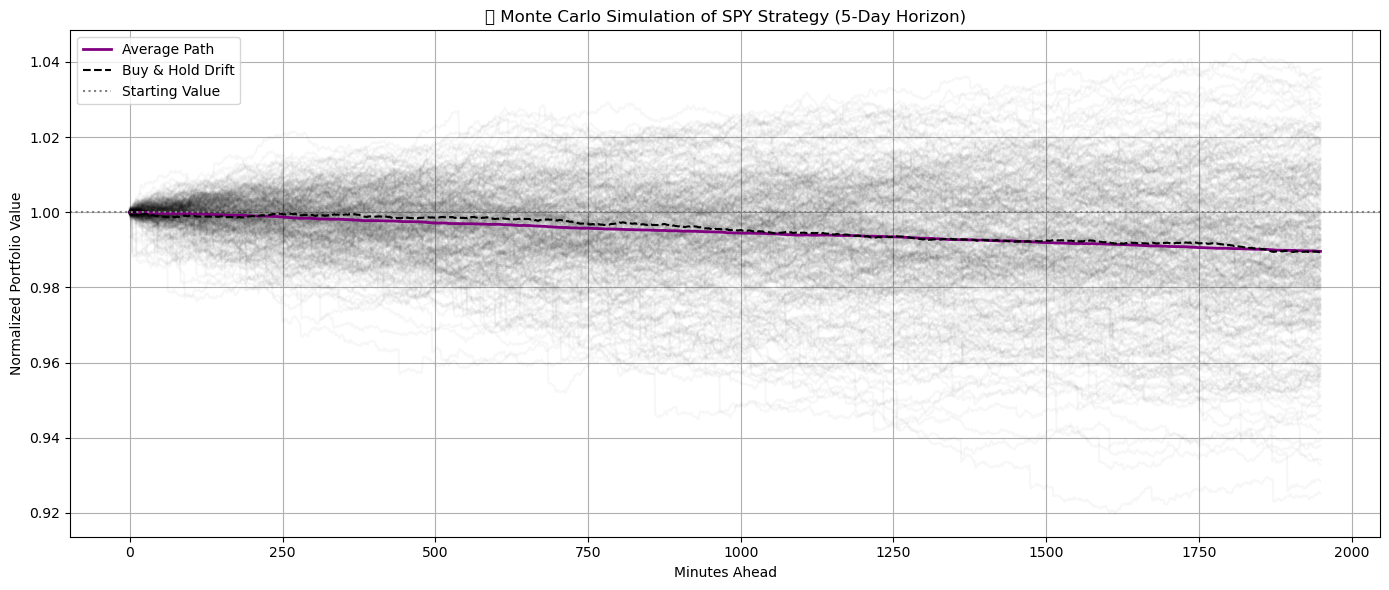

In [169]:
simulate_monte_carlo(
    ticker="SPY",
    returns_df=returns,    # your historical 1-min strategy returns (Series)
    days=5,
    simulations=1000,
    buy_hold=True
)

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_monte_carlo(ticker, returns_df, days=5, simulations=1000, buy_hold=True, seed=42):
    """
    Simulate Monte Carlo paths for a trading strategy and optionally compare to Buy & Hold drift.

    Parameters:
    - ticker (str): Symbol of the asset being tested
    - returns_df (pd.Series): Historical strategy returns (1m frequency)
    - days (int): Number of days to simulate into the future
    - simulations (int): Number of Monte Carlo paths to generate
    - buy_hold (bool): Whether to plot a Buy & Hold drift line
    - seed (int): Random seed for reproducibility
    """
    np.random.seed(seed)
    minutes = days * 390  # Trading minutes in a day
    start_value = 1
    paths = np.zeros((simulations, minutes))
    
    for i in range(simulations):
        sampled_returns = np.random.choice(returns_df, size=minutes, replace=True)
        paths[i] = start_value * np.cumprod(1 + sampled_returns)

    avg_path = np.mean(paths, axis=0)
    percentile_5 = np.percentile(paths, 5, axis=0)
    percentile_95 = np.percentile(paths, 95, axis=0)

    # Risk Metrics
    final_values = paths[:, -1]
    var_5 = np.percentile(final_values, 5)
    cvar_5 = final_values[final_values <= var_5].mean()
    prob_loss = np.mean(final_values < 1)
    prob_gain = np.mean(final_values > 1)

    # Plotting
    plt.figure(figsize=(14, 6))
    for i in range(min(simulations, 300)):
        plt.plot(paths[i], color='black', alpha=0.03)
    plt.plot(avg_path, color='purple', label='Average Path', linewidth=2)
    plt.plot(percentile_5, linestyle='--', color='red', label='5th Percentile')
    plt.plot(percentile_95, linestyle='--', color='green', label='95th Percentile')

    if buy_hold:
        drift_return = returns_df.mean()
        bh_returns = np.random.normal(loc=drift_return, scale=returns_df.std() * 0.1, size=minutes)
        bh_growth = start_value * np.cumprod(1 + bh_returns)
        if np.all(bh_growth > 0.5):
            plt.plot(bh_growth, linestyle='--', color='black', label='Buy & Hold Drift')

    plt.axhline(1, color='gray', linestyle=':', label='Starting Value')
    plt.title(f"🎲 Monte Carlo Simulation of {ticker} Strategy ({days}-Day Horizon)")
    plt.xlabel("Minutes Ahead")
    plt.ylabel("Normalized Portfolio Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print risk metrics
    print("Monte Carlo Risk Summary")
    print(f"- Value at Risk (5%): {var_5:.4f} ({(var_5 - 1) * 100:.2f}%)")
    print(f"- Conditional VaR (Expected Shortfall): {cvar_5:.4f} ({(cvar_5 - 1) * 100:.2f}%)")
    print(f"- Probability of Loss: {prob_loss * 100:.2f}%")
    print(f"- Probability of Gain: {prob_gain * 100:.2f}%")


/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/1994190177.py:58: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


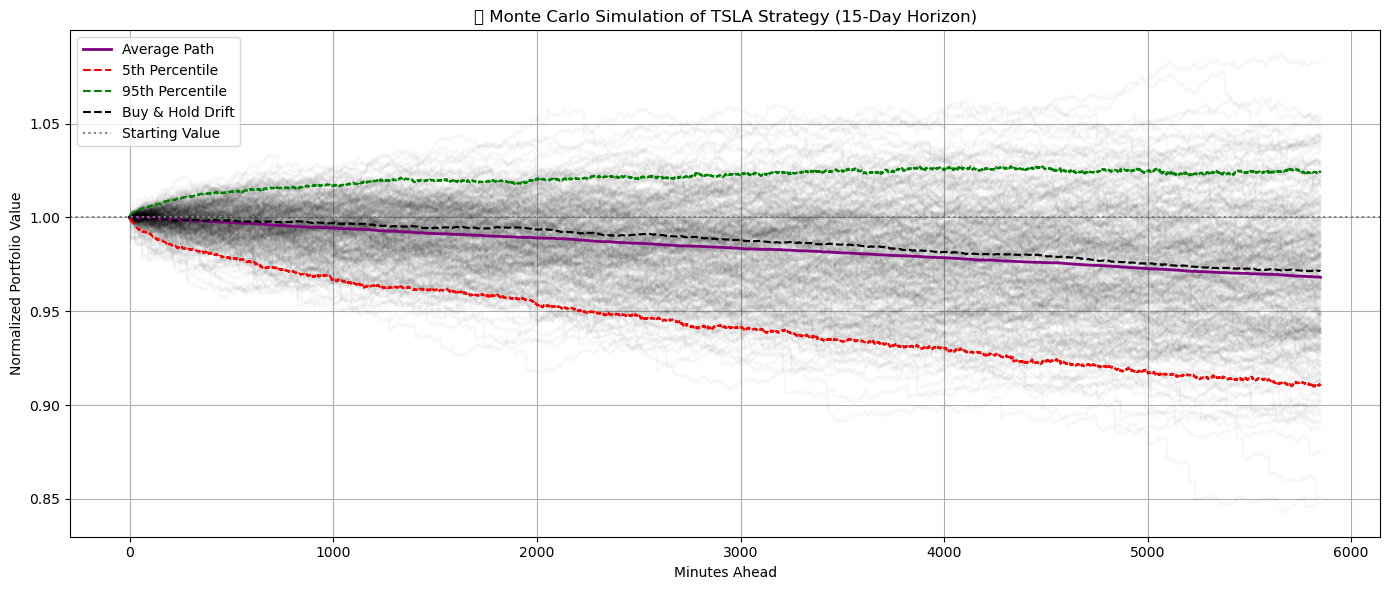

📊 Monte Carlo Risk Summary
- Value at Risk (5%): 0.9110 (-8.90%)
- Conditional VaR (Expected Shortfall): 0.8949 (-10.51%)
- Probability of Loss: 82.20%
- Probability of Gain: 17.80%


In [195]:
simulate_monte_carlo(
    ticker="TSLA",
    returns_df=returns,    # your historical 1-min strategy returns (Series)
    days=15,
    simulations=1000,
    buy_hold=True
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


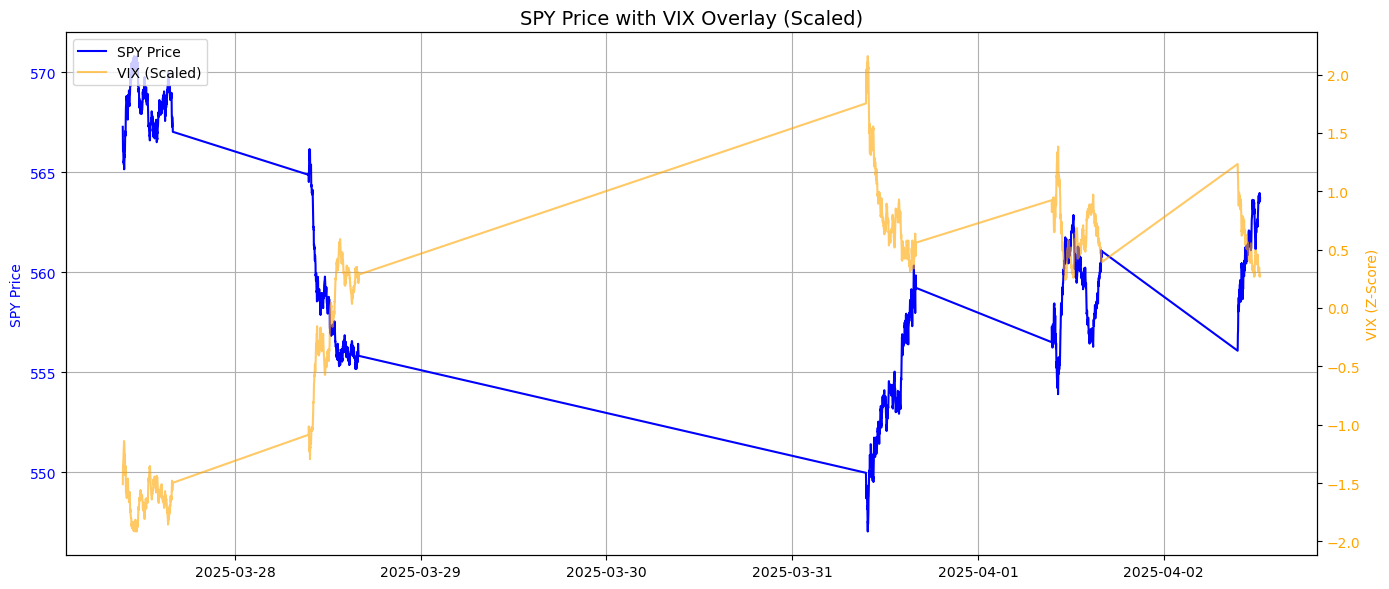

In [205]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
symbol = "SPY"
vix_symbol = "^VIX"
interval = "1m"
period = "5d"

# Download data
spy = yf.download(symbol, interval=interval, period=period)
vix = yf.download(vix_symbol, interval=interval, period=period)

# Ensure datetime format and timezone alignment
for df in [spy, vix]:
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    if df.index.tz is None:
        df.index = df.index.tz_localize("America/New_York")
    else:
        df.index = df.index.tz_convert("America/New_York")

# Align both datasets
combined = pd.merge(
    spy[['Close']].rename(columns={'Close': 'SPY_Close'}),
    vix[['Close']].rename(columns={'Close': 'VIX_Close'}),
    left_index=True, right_index=True, how='inner'
)

# Normalize VIX for dual-axis plotting
combined['VIX_Scaled'] = (combined['VIX_Close'] - combined['VIX_Close'].mean()) / combined['VIX_Close'].std()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_title("SPY Price with VIX Overlay (Scaled)", fontsize=14)
ax1.plot(combined.index, combined['SPY_Close'], label="SPY Price", color='blue')
ax1.set_ylabel("SPY Price", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(combined.index, combined['VIX_Scaled'], label="VIX (Scaled)", color='orange', alpha=0.6)
ax2.set_ylabel("VIX (Z-Score)", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Running: SPY
Running: QQQ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Running: AAPL



[*********************100%***********************]  1 of 1 completed

Running: MSFT



/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/1887042341.py:193: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


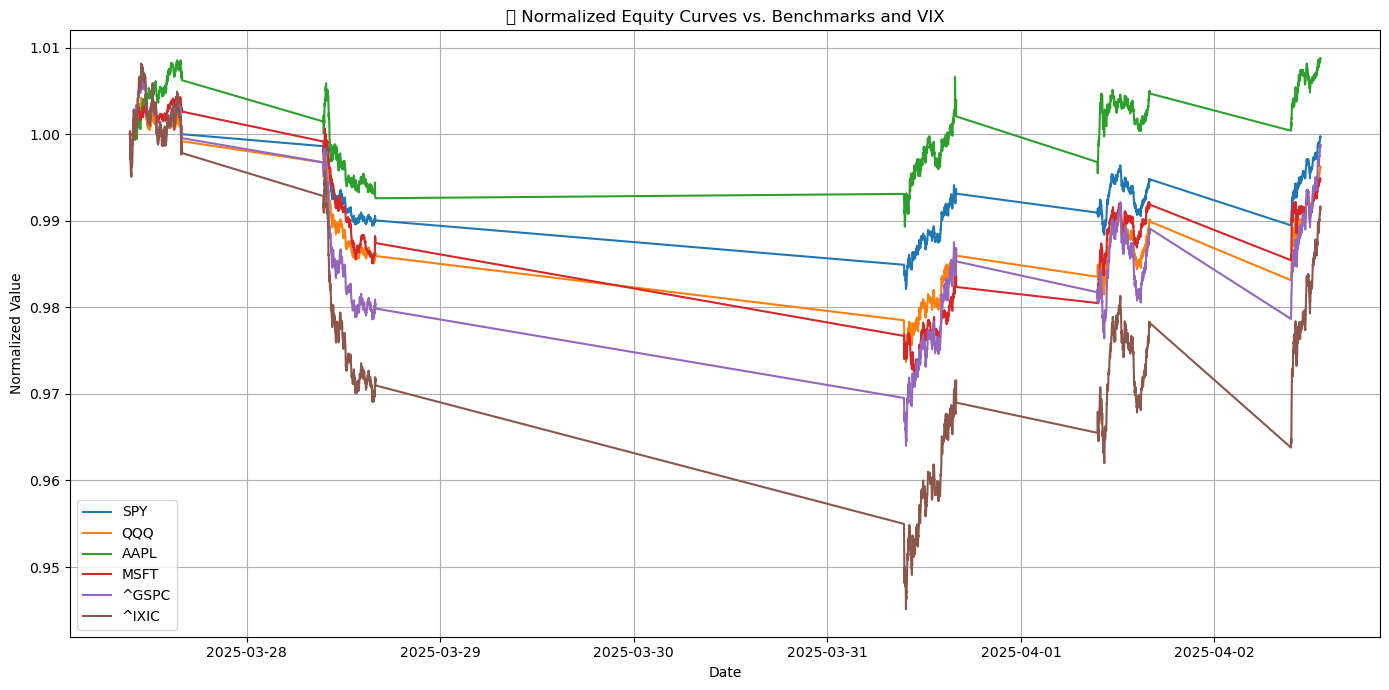


Multi-Ticker Strategy Results with Risk Metrics:



,Ticker,Final Value ($),Strategy Return (%),Buy & Hold Return (%),Outperformed (%),Buys,Sells,Trades,Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Status
0,SPY,19992.81,-0.04,-0.10,0.06,846,897,1743,-0.16,-0.17,-2.11,Beat Market
1,QQQ,19922.82,-0.39,-0.81,0.42,847,891,1738,-1.64,-1.64,-3.04,Beat Market
2,AAPL,20173.69,0.87,1.69,-0.82,865,865,1730,3.69,4.24,-1.90,Underperformed
3,MSFT,19895.28,-0.52,-1.09,0.57,854,880,1734,-1.97,-1.83,-3.22,Beat Market


In [219]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Strategy Configuration
# ------------------------------
tickers = ["SPY", "QQQ", "AAPL", "MSFT"]
benchmarks = ["^GSPC", "^IXIC"]
interval = "1m"
period = "5d"

initial_investment = 10000
backup_cash = 10000
starting_capital = initial_investment + backup_cash

Z_BUY = -3.0
Z_SELL = 3.0
MAX_POSITION_RATIO = 0.75
MIN_CASH_BUFFER = 2000
window = 20
enable_zscore = False  # Toggle this to use z-score logic

results = []
equity_curves = {}

# ------------------------------
# Fetch Benchmark Data
# ------------------------------
benchmark_data = {}
for bmk in benchmarks:
    df_bmk = yf.download(bmk, interval=interval, period=period)['Close'].dropna()
    df_bmk = df_bmk.tz_localize("America/New_York") if df_bmk.index.tz is None else df_bmk.tz_convert("America/New_York")
    benchmark_data[bmk] = df_bmk

# ------------------------------
# Fetch VIX Data
# ------------------------------
vix_symbol = "^VIX"
vix = yf.download(vix_symbol, interval=interval, period=period)
vix.columns = vix.columns.get_level_values(0) if isinstance(vix.columns, pd.MultiIndex) else vix.columns
vix = vix[['Close']].rename(columns={'Close': 'VIX_Close'})
vix.index = pd.to_datetime(vix.index)
vix = vix.tz_localize("America/New_York") if vix.index.tz is None else vix.tz_convert("America/New_York")

# ------------------------------
# Run Backtest Per Ticker
# ------------------------------
for symbol in tickers:
    print(f"Running: {symbol}")
    try:
        df = yf.download(symbol, interval=interval, period=period)
        df.columns = df.columns.get_level_values(0) if isinstance(df.columns, pd.MultiIndex) else df.columns
        df.index = pd.to_datetime(df.index).sort_values()
        df = df.tz_localize("America/New_York") if df.index.tz is None else df.tz_convert("America/New_York")
        df = df.between_time("09:30", "16:00")
        df = df[df.index.dayofweek < 5]
        df['Close'] = df['Close'].astype(float)

        # Merge VIX into strategy DataFrame
        df = df.merge(vix, left_index=True, right_index=True, how='left')
        df['VIX_Close'] = df['VIX_Close'].ffill()

        # Z-score Calculation
        df['zscore'] = (df['Close'] - df['Close'].rolling(window).mean()) / df['Close'].rolling(window).std()

        # --- Portfolio Initialization ---
        shares = 0
        buy_count = 0
        sell_count = 0
        has_liquidated = False
        backup_cash_copy = backup_cash
        portfolio_series = []

        entry_price = df['Close'].iloc[window]
        shares = initial_investment / entry_price
        equity_value = shares * entry_price
        portfolio_series = [np.nan] * window + [equity_value + backup_cash_copy]
        buy_count += 1

        # --- Strategy Execution Loop ---
        for i in range(window + 1, len(df)):
            price = df['Close'].iloc[i]
            z = df['zscore'].iloc[i]
            prev_price = df['Close'].iloc[i - 1]
            price_change = (price - prev_price) / prev_price

            equity_value = shares * price
            portfolio_value = backup_cash_copy + equity_value
            portfolio_series.append(portfolio_value)

            if has_liquidated:
                continue

            position_value = shares * price
            max_position_value = portfolio_value * MAX_POSITION_RATIO

            if enable_zscore:
                if z < Z_BUY:
                    drop_pct = abs(z) / 3
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1

                elif z > Z_SELL and shares > 0:
                    climb_pct = z / 3
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1
            else:
                if price_change < 0:
                    drop_pct = abs(price_change)
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1

                elif price_change > 0 and shares > 0:
                    climb_pct = price_change
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1

        # --- Metrics ---
        final_price = df['Close'].iloc[-1]
        final_value = backup_cash_copy + shares * final_price
        cumulative_return = (final_value - starting_capital) / starting_capital * 100

        bh_shares = initial_investment / entry_price
        bh_value = bh_shares * final_price
        bh_return = (bh_value - initial_investment) / initial_investment * 100

        portfolio_series = pd.Series(portfolio_series, index=df.index)
        returns = portfolio_series.pct_change().dropna()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252 * 6.5 * 60)
        sortino_ratio = (returns.mean() / returns[returns < 0].std()) * np.sqrt(252 * 6.5 * 60)
        drawdown = portfolio_series / portfolio_series.cummax() - 1
        max_drawdown = drawdown.min() * 100

        results.append({
            "Ticker": symbol,
            "Final Value ($)": round(final_value, 2),
            "Strategy Return (%)": round(cumulative_return, 2),
            "Buy & Hold Return (%)": round(bh_return, 2),
            "Outperformed (%)": round(cumulative_return - bh_return, 2),
            "Buys": buy_count,
            "Sells": sell_count,
            "Trades": buy_count + sell_count,
            "Sharpe Ratio": round(sharpe_ratio, 2),
            "Sortino Ratio": round(sortino_ratio, 2),
            "Max Drawdown (%)": round(max_drawdown, 2),
            "Status": "Beat Market" if cumulative_return > bh_return else "Underperformed"
        })

        equity_curves[symbol] = portfolio_series / portfolio_series.iloc[window]

    except Exception as e:
        print(f"Error for {symbol}: {e}")

# ------------------------------
# Add Benchmarks to Equity Plot
# ------------------------------
valid_tickers = [t for t in tickers if t in equity_curves]
if valid_tickers:
    for bmk in benchmark_data:
        bmk_series = benchmark_data[bmk]
        bmk_series = bmk_series[bmk_series.index.isin(equity_curves[valid_tickers[0]].index)]
        equity_curves[bmk] = bmk_series / bmk_series.iloc[0]

# ------------------------------
# Plot Equity Curves
# ------------------------------
plt.figure(figsize=(14, 7))
for symbol, series in equity_curves.items():
    plt.plot(series.index, series.values, label=symbol)
plt.title("📈 Normalized Equity Curves vs. Benchmarks and VIX")
plt.legend()
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.tight_layout()
plt.show()

# ------------------------------
# Display Performance Summary
# ------------------------------
results_df = pd.DataFrame(results)
print("\nMulti-Ticker Strategy Results with Risk Metrics:\n")
display(results_df)

/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/1994190177.py:58: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


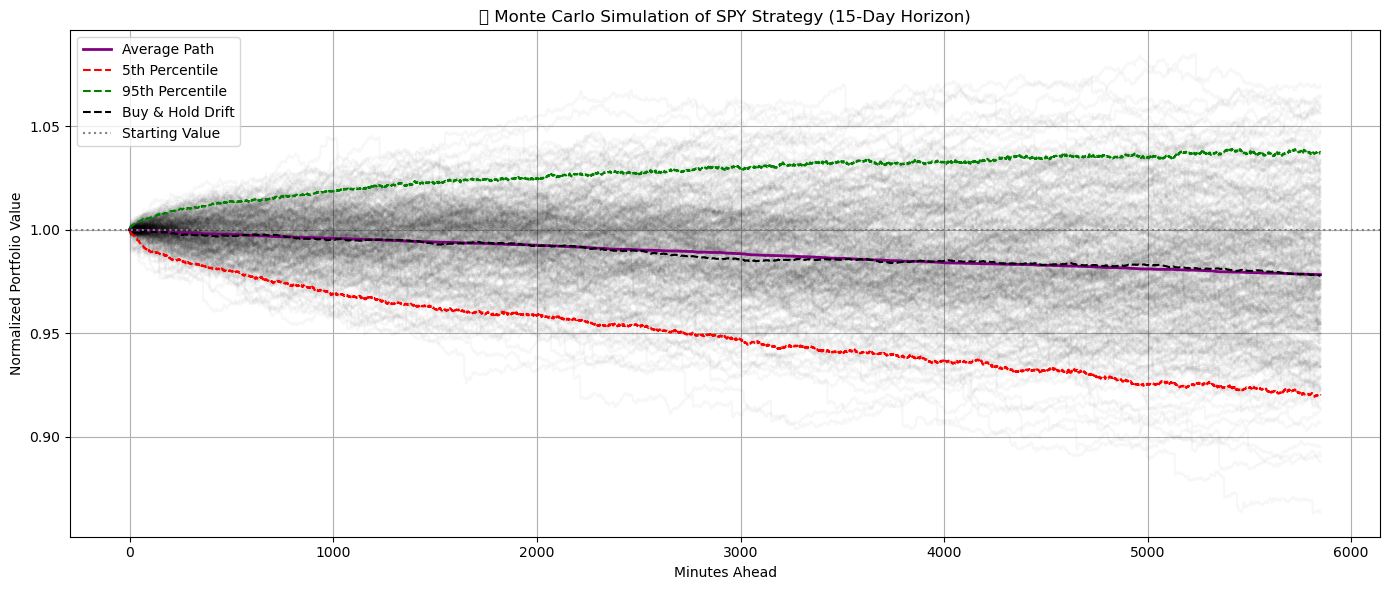

📊 Monte Carlo Risk Summary
- Value at Risk (5%): 0.9205 (-7.95%)
- Conditional VaR (Expected Shortfall): 0.9060 (-9.40%)
- Probability of Loss: 73.60%
- Probability of Gain: 26.40%


In [213]:
simulate_monte_carlo(
    ticker="SPY",
    returns_df=returns,    # your historical 1-min strategy returns (Series)
    days=15,
    simulations=1000,
    buy_hold=True
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Running: SPY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Running: QQQ



[*********************100%***********************]  1 of 1 completed


Running: AAPL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Running: MSFT



/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/1812788461.py:199: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


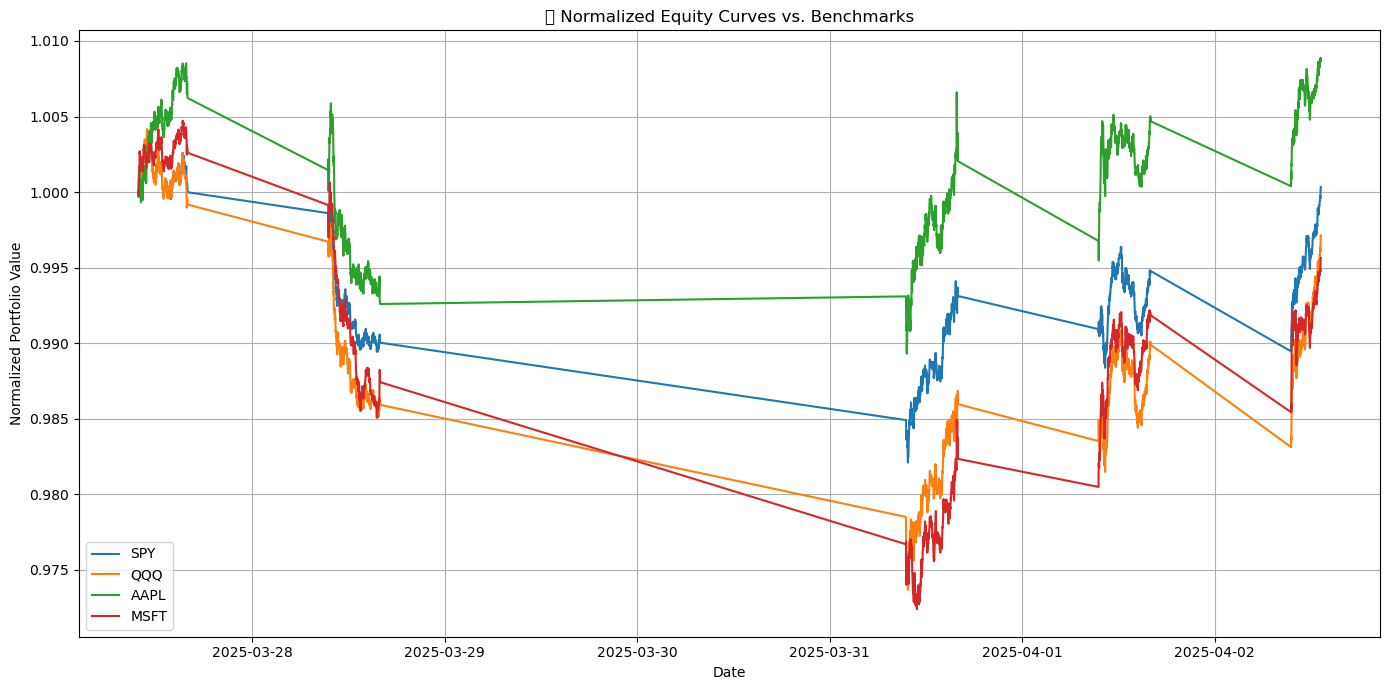


Multi-Ticker Strategy Results with Risk Metrics:



,Ticker,Final Value ($),Strategy Return (%),Buy & Hold Return (%),Outperformed (%),Buys,Sells,Trades,Sharpe Ratio,Sortino Ratio,Max Drawdown (%),Status
0,SPY,20006.61,0.03,0.04,-0.01,846,901,1747,0.24,0.25,-2.11,Underperformed
1,QQQ,19942.11,-0.29,-0.61,0.32,848,894,1742,-1.21,-1.21,-3.04,Beat Market
2,AAPL,20175.36,0.88,1.71,-0.83,866,867,1733,3.72,4.27,-1.90,Underperformed
3,MSFT,19912.97,-0.44,-0.92,0.48,854,884,1738,-1.62,-1.51,-3.22,Beat Market


In [221]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# Strategy Configuration with VIX Filtering
# -----------------------------------------
tickers = ["SPY", "QQQ", "AAPL", "MSFT"]
benchmarks = ["^GSPC", "^IXIC"]
interval = "1m"
period = "5d"

initial_investment = 10000
backup_cash = 10000
starting_capital = initial_investment + backup_cash

Z_BUY = -3.0
Z_SELL = 3.0
MAX_POSITION_RATIO = 0.75
MIN_CASH_BUFFER = 2000
window = 20

enable_zscore = False         # Toggle Z-score logic
enable_vix_filter = True      # Toggle VIX-based trade filtering
vix_min = 13                  # Min VIX threshold for trades
vix_max = 25                  # Max VIX threshold for trades

results = []
equity_curves = {}

# ------------------------------
# Fetch Benchmark Data
# ------------------------------
benchmark_data = {}
for bmk in benchmarks:
    df_bmk = yf.download(bmk, interval=interval, period=period)['Close'].dropna()
    df_bmk = df_bmk.tz_localize("America/New_York") if df_bmk.index.tz is None else df_bmk.tz_convert("America/New_York")
    benchmark_data[bmk] = df_bmk

# ------------------------------
# Backtest Loop with VIX Overlay
# ------------------------------
for symbol in tickers:
    print(f"Running: {symbol}")
    try:
        # Download price and VIX
        df = yf.download(symbol, interval=interval, period=period)
        vix = yf.download("^VIX", interval=interval, period=period)

        # Preprocess
        df.columns = df.columns.get_level_values(0)
        vix.columns = vix.columns.get_level_values(0)
        df.index = pd.to_datetime(df.index).sort_values()
        vix.index = pd.to_datetime(vix.index).sort_values()
        df = df.tz_localize("America/New_York") if df.index.tz is None else df.tz_convert("America/New_York")
        vix = vix.tz_localize("America/New_York") if vix.index.tz is None else vix.tz_convert("America/New_York")

        df = df.between_time("09:30", "16:00")
        vix = vix.between_time("09:30", "16:00")
        df = df[df.index.dayofweek < 5]
        vix = vix[vix.index.dayofweek < 5]

        df['Close'] = df['Close'].astype(float)
        vix = vix[['Close']].rename(columns={'Close': 'VIX'})

        # Merge VIX into main df
        df = df.merge(vix, left_index=True, right_index=True, how='left')
        df['VIX'] = df['VIX'].ffill()

        # Z-score calculation
        df['zscore'] = (df['Close'] - df['Close'].rolling(window).mean()) / df['Close'].rolling(window).std()

        # Initialize portfolio state
        shares = 0
        buy_count = 0
        sell_count = 0
        has_liquidated = False
        backup_cash_copy = backup_cash
        portfolio_series = []

        # Initial Buy
        entry_price = df['Close'].iloc[window]
        shares = initial_investment / entry_price
        equity_value = shares * entry_price
        portfolio_series = [np.nan] * window + [equity_value + backup_cash_copy]
        buy_count += 1

        # Strategy Loop
        for i in range(window + 1, len(df)):
            row = df.iloc[i]
            price = row['Close']
            z = row['zscore']
            vix_value = row['VIX']
            prev_price = df['Close'].iloc[i - 1]
            price_change = (price - prev_price) / prev_price

            equity_value = shares * price
            portfolio_value = backup_cash_copy + equity_value
            portfolio_series.append(portfolio_value)

            if has_liquidated:
                continue

            position_value = shares * price
            max_position_value = portfolio_value * MAX_POSITION_RATIO

            # Skip if VIX outside range
            if enable_vix_filter and not (vix_min <= vix_value <= vix_max):
                continue

            # Trading Logic
            if enable_zscore:
                if z < Z_BUY:
                    drop_pct = abs(z) / 3
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1
                elif z > Z_SELL and shares > 0:
                    climb_pct = z / 3
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1
            else:
                if price_change < 0:
                    drop_pct = abs(price_change)
                    investment = min(backup_cash_copy * drop_pct, max_position_value - position_value)
                    if investment > 0 and backup_cash_copy - investment >= MIN_CASH_BUFFER:
                        bought_shares = investment / price
                        shares += bought_shares
                        backup_cash_copy -= investment
                        buy_count += 1
                elif price_change > 0 and shares > 0:
                    climb_pct = price_change
                    sell_shares = min(shares, shares * climb_pct)
                    if sell_shares > 0:
                        proceeds = sell_shares * price
                        backup_cash_copy += proceeds
                        shares -= sell_shares
                        sell_count += 1

        # Final metrics
        final_price = df['Close'].iloc[-1]
        final_value = backup_cash_copy + shares * final_price
        cumulative_return = (final_value - starting_capital) / starting_capital * 100

        # Buy & Hold
        bh_shares = initial_investment / entry_price
        bh_value = bh_shares * final_price
        bh_return = (bh_value - initial_investment) / initial_investment * 100

        # Risk metrics
        portfolio_series = pd.Series(portfolio_series, index=df.index)
        returns = portfolio_series.pct_change().dropna()
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252 * 6.5 * 60)
        sortino_ratio = (returns.mean() / returns[returns < 0].std()) * np.sqrt(252 * 6.5 * 60)
        drawdown = portfolio_series / portfolio_series.cummax() - 1
        max_drawdown = drawdown.min() * 100

        results.append({
            "Ticker": symbol,
            "Final Value ($)": round(final_value, 2),
            "Strategy Return (%)": round(cumulative_return, 2),
            "Buy & Hold Return (%)": round(bh_return, 2),
            "Outperformed (%)": round(cumulative_return - bh_return, 2),
            "Buys": buy_count,
            "Sells": sell_count,
            "Trades": buy_count + sell_count,
            "Sharpe Ratio": round(sharpe_ratio, 2),
            "Sortino Ratio": round(sortino_ratio, 2),
            "Max Drawdown (%)": round(max_drawdown, 2),
            "Status": "Beat Market" if cumulative_return > bh_return else "Underperformed"
        })

        equity_curves[symbol] = portfolio_series / portfolio_series.iloc[window]

    except Exception as e:
        print(f"Error for {symbol}: {e}")


# ------------------------------
# Plot Equity Curves
# ------------------------------
plt.figure(figsize=(14, 7))
for symbol, series in equity_curves.items():
    plt.plot(series.index, series.values, label=symbol)

plt.title("📊 Normalized Equity Curves vs. Benchmarks")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Display Performance Summary
# ------------------------------
results_df = pd.DataFrame(results)
print("\nMulti-Ticker Strategy Results with Risk Metrics:\n")
display(results_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


📊 Low VIX Regime Risk Summary:
- Value at Risk (5%): 0.9602 (-3.98%)
- Conditional VaR (Expected Shortfall): 0.9524 (-4.76%)
- Probability of Loss: 72.20%
- Probability of Gain: 27.80%
--------------------------------------------------
📊 High VIX Regime Risk Summary:
- Value at Risk (5%): 0.9514 (-4.86%)
- Conditional VaR (Expected Shortfall): 0.9330 (-6.70%)
- Probability of Loss: 39.50%
- Probability of Gain: 60.50%
--------------------------------------------------


/var/folders/pv/mkxvrtmj3p531hhmkxtn40tw0000gn/T/ipykernel_4662/713997972.py:82: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


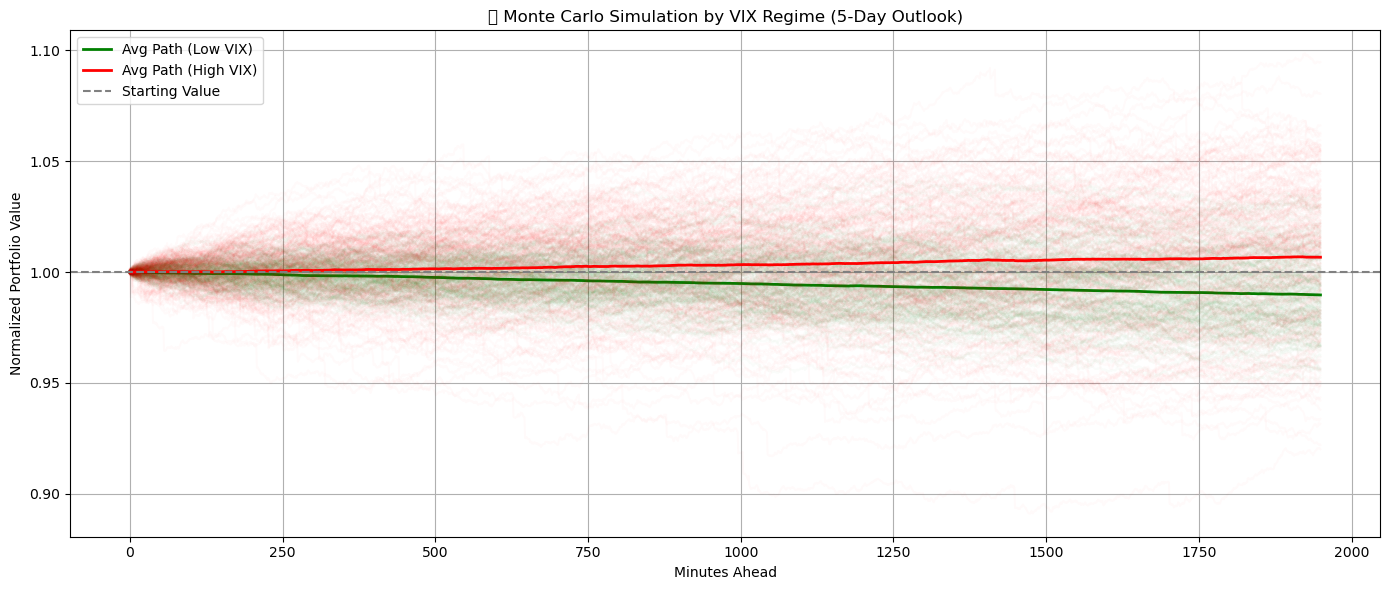

In [223]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Fetch 1m SPY & VIX data
# -------------------------
spy = yf.download("SPY", interval="1m", period="5d")
vix = yf.download("^VIX", interval="1m", period="5d")

# Clean timestamps
spy.index = pd.to_datetime(spy.index).tz_localize(None)
vix.index = pd.to_datetime(vix.index).tz_localize(None)

# Merge and forward-fill VIX
df = pd.DataFrame(index=spy.index)
df['SPY_Close'] = spy['Close']
df['VIX'] = vix['Close'].reindex(df.index, method='ffill')
df = df.dropna()

# Calculate returns and classify volatility regime
df['Returns'] = df['SPY_Close'].pct_change().fillna(0)
vix_threshold = df['VIX'].median()
df['Volatility_Regime'] = np.where(df['VIX'] > vix_threshold, 'High VIX', 'Low VIX')

# Split returns
low_vix_returns = df[df['Volatility_Regime'] == 'Low VIX']['Returns']
high_vix_returns = df[df['Volatility_Regime'] == 'High VIX']['Returns']

# -------------------------
# Monte Carlo Simulation
# -------------------------
def monte_carlo_with_risk_metrics(returns, label, simulations=1000, days=5, seed=42):
    np.random.seed(seed)
    minutes = days * 390
    start_value = 1
    paths = np.zeros((simulations, minutes))

    for i in range(simulations):
        sampled_returns = np.random.choice(returns, size=minutes, replace=True)
        paths[i] = start_value * np.cumprod(1 + sampled_returns)

    final_values = paths[:, -1]
    avg_path = np.mean(paths, axis=0)
    pct_5 = np.percentile(paths, 5, axis=0)
    pct_95 = np.percentile(paths, 95, axis=0)

    # Risk Metrics
    var_5 = np.percentile(final_values, 5)
    cvar_5 = final_values[final_values <= var_5].mean()
    prob_loss = np.mean(final_values < 1)
    prob_gain = np.mean(final_values > 1)

    # Plot
    for i in range(min(simulations, 200)):
        plt.plot(paths[i], alpha=0.02, color='green' if label == 'Low VIX' else 'red')
    plt.plot(avg_path, linewidth=2, label=f"Avg Path ({label})", color='green' if label == 'Low VIX' else 'red')

    # Print metrics
    print(f"📊 {label} Regime Risk Summary:")
    print(f"- Value at Risk (5%): {var_5:.4f} ({(var_5 - 1) * 100:.2f}%)")
    print(f"- Conditional VaR (Expected Shortfall): {cvar_5:.4f} ({(cvar_5 - 1) * 100:.2f}%)")
    print(f"- Probability of Loss: {prob_loss * 100:.2f}%")
    print(f"- Probability of Gain: {prob_gain * 100:.2f}%")
    print("-" * 50)

# -------------------------
# Run Both Regimes
# -------------------------
plt.figure(figsize=(14, 6))
monte_carlo_with_risk_metrics(low_vix_returns, label="Low VIX")
monte_carlo_with_risk_metrics(high_vix_returns, label="High VIX")

# Final plot tweaks
plt.axhline(1, color='gray', linestyle='--', label="Starting Value")
plt.title("🎲 Monte Carlo Simulation by VIX Regime (5-Day Outlook)")
plt.xlabel("Minutes Ahead")
plt.ylabel("Normalized Portfolio Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [227]:
def monte_carlo_by_vix_streamlit(symbol="SPY", interval="1m", period="5d", simulations=1000, days=5, seed=42):
    """
    Monte Carlo simulation for symbol returns, split by VIX regime (high vs low).
    Outputs charts and risk stats using Streamlit.
    """
    st.subheader("📉 Monte Carlo Stress Test by Volatility Regime")

    with st.spinner("Fetching data..."):
        spy = yf.download(symbol, interval=interval, period=period)
        vix = yf.download("^VIX", interval=interval, period=period)

    spy.index = pd.to_datetime(spy.index).tz_localize(None)
    vix.index = pd.to_datetime(vix.index).tz_localize(None)

    df = pd.DataFrame(index=spy.index)
    df['Price'] = spy['Close']
    df['VIX'] = vix['Close'].reindex(df.index, method='ffill')
    df = df.dropna()

    df['Returns'] = df['Price'].pct_change().fillna(0)
    vix_threshold = df['VIX'].median()
    df['Volatility_Regime'] = np.where(df['VIX'] > vix_threshold, 'High VIX', 'Low VIX')

    low_vix_returns = df[df['Volatility_Regime'] == 'Low VIX']['Returns']
    high_vix_returns = df[df['Volatility_Regime'] == 'High VIX']['Returns']

    fig, ax = plt.subplots(figsize=(14, 6))

    def simulate_and_plot(returns, label, color):
        np.random.seed(seed)
        minutes = days * 390
        start_value = 1
        paths = np.zeros((simulations, minutes))

        for i in range(simulations):
            sampled_returns = np.random.choice(returns, size=minutes, replace=True)
            paths[i] = start_value * np.cumprod(1 + sampled_returns)

        final_values = paths[:, -1]
        avg_path = np.mean(paths, axis=0)

        var_5 = np.percentile(final_values, 5)
        cvar_5 = final_values[final_values <= var_5].mean()
        prob_loss = np.mean(final_values < 1)
        prob_gain = np.mean(final_values > 1)

        for i in range(min(simulations, 200)):
            ax.plot(paths[i], alpha=0.02, color=color)
        ax.plot(avg_path, linewidth=2, label=f"Avg Path ({label})", color=color)

        return {
            "Regime": label,
            "VaR (5%)": f"{var_5:.4f}",
            "Conditional VaR": f"{cvar_5:.4f}",
            "Prob Loss (%)": f"{prob_loss * 100:.2f}%",
            "Prob Gain (%)": f"{prob_gain * 100:.2f}%"
        }

    metrics_low = simulate_and_plot(low_vix_returns, "Low VIX", "green")
    metrics_high = simulate_and_plot(high_vix_returns, "High VIX", "red")

    ax.axhline(1, color='gray', linestyle='--', label="Starting Value")
    ax.set_title(f"🎲 Monte Carlo Simulation by VIX Regime ({days}-Day Outlook)")
    ax.set_xlabel("Minutes Ahead")
    ax.set_ylabel("Normalized Portfolio Value")
    ax.grid(True)
    ax.legend()
    st.pyplot(fig)

    st.markdown("### 📊 Risk Summary by Regime")
    st.write("Median VIX value used as cutoff:", round(vix_threshold, 2))
    st.dataframe(pd.DataFrame([metrics_low, metrics_high]))